<a href="https://colab.research.google.com/github/Ark1645/Deep-Learning/blob/main/Copy_of_Report_UCSD_200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Bird Classification

Dataset Used:Caltech-UCSD Birds 200 (CUB-200)
It is an image dataset with photos of 200 bird species (mostly North American).

Number of Categories: 200

Number of Images: 6,033

Annotations: Bounding Box, Rough Segmentation, Attributes
Since we are classsfying we can use only the images and lists files.

Images:648 MB

Lists: with class names, train/test splits, etc.

Usually every class had around 22-36 Images but data augmentation gave more data and decreased the influence of imbalance in data.

So lets move further and go through the different blocks in the notebook.

###Data Extracter Block

Extracting All the required Files.

In [ ]:
!tar -xf /content/drive/"My Drive"/"UCSD 200"/images.tgz

In [ ]:
!tar -xf /content/drive/"My Drive"/"UCSD 200"/lists.tgz

In [ ]:
mkdir bird

In [ ]:
mv /content/lists /content/bird

In [ ]:
mv /content/images /content/bird

###Package Imports Block

In [ ]:
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import floor
import random
print(os.listdir("../content"))

['.config', 'drive', 'sample_data']


In [ ]:
data_path='/content/drive/MyDrive/Machine_Learning_Datas/CUB_200_2011/images'

In [ ]:
from glob import glob

### Dataviewer Block

Visualizing the Data:

In [ ]:
def BirdView(genera):
  print("Samples images for Bird " + genera)
  root_path='/content/drive/MyDrive/Machine_Learning_Datas/CUB_200_2011/images/'
  img_path=root_path+genera+'/**'
  images =glob(img_path)
  plt.figure(figsize=(16,16))
  img=random.sample(images,3)
  plt.subplot(131)
  plt.imshow(cv2.imread(img[0]))
  plt.subplot(132)
  plt.imshow(cv2.imread(img[1]))
  plt.subplot(133)
  plt.imshow(cv2.imread(img[2]))
  return

Samples images for Bird 043.Yellow_bellied_Flycatcher


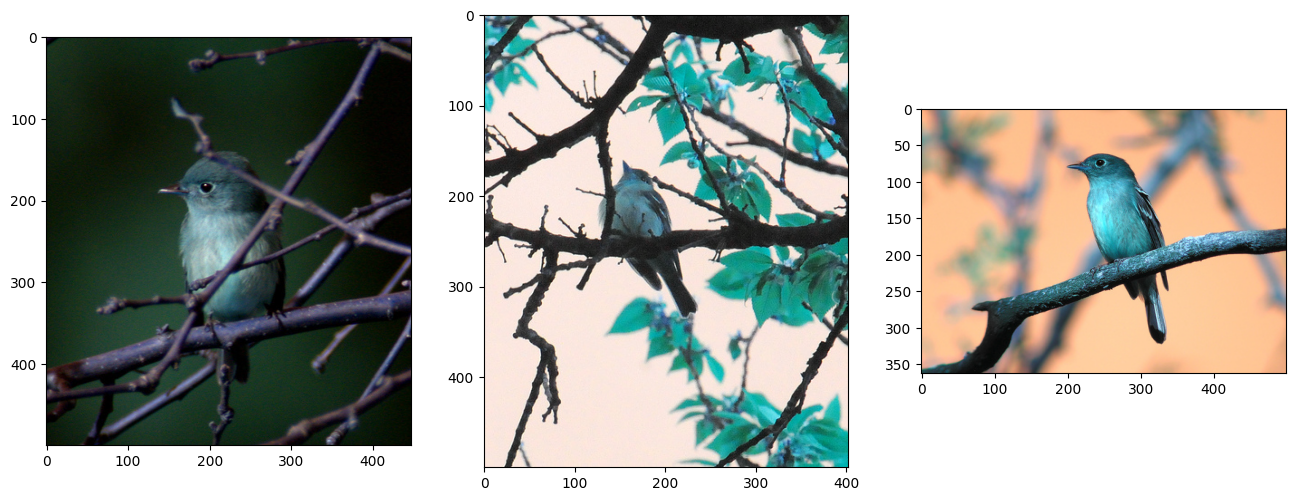

In [ ]:
BirdView('043.Yellow_bellied_Flycatcher')

In [ ]:
print(os.listdir('/content/drive/MyDrive/Machine_Learning_Datas/CUB_200_2011/images'))

['198.Rock_Wren', '200.Common_Yellowthroat', '199.Winter_Wren', '195.Carolina_Wren', '197.Marsh_Wren', '196.House_Wren', '194.Cactus_Wren', '191.Red_headed_Woodpecker', '192.Downy_Woodpecker', '189.Red_bellied_Woodpecker', '190.Red_cockaded_Woodpecker', '188.Pileated_Woodpecker', '193.Bewick_Wren', '185.Bohemian_Waxwing', '186.Cedar_Waxwing', '184.Louisiana_Waterthrush', '187.American_Three_toed_Woodpecker', '180.Wilson_Warbler', '178.Swainson_Warbler', '181.Worm_eating_Warbler', '179.Tennessee_Warbler', '182.Yellow_Warbler', '183.Northern_Waterthrush', '173.Orange_crowned_Warbler', '177.Prothonotary_Warbler', '175.Pine_Warbler', '172.Nashville_Warbler', '174.Palm_Warbler', '176.Prairie_Warbler', '171.Myrtle_Warbler', '169.Magnolia_Warbler', '166.Golden_winged_Warbler', '167.Hooded_Warbler', '168.Kentucky_Warbler', '170.Mourning_Warbler', '165.Chestnut_sided_Warbler', '162.Canada_Warbler', '164.Cerulean_Warbler', '163.Cape_May_Warbler', '158.Bay_breasted_Warbler', '161.Blue_winged_Warb

"._"  files, these invisible files are "resource fork" segments of files that are being created on the external volume.
These were created after running the linux command


These cause the Datagenerator(os.listdir()) function loop to extract all files TWICE since both point to same file, took me a while to figure it out

So I wrote a function to remove such files


In [ ]:
import glob


def delete_files(path, pattern):
    for f in glob.iglob(os.path.join(path, pattern)):
        try:
            os.remove(f)
        except OSError as exc:
            print (exc)

Note:Its optional to delete them, sometimes when you have limited data it is a uncommmon but useful practice to use dataset again as long as the model does not overfit it is applicable but be careful if you do so.

In [ ]:
delete_files(data_path, '._**')

###Label Dictionary Block

So to label all the images during processing and augmentation ,we need a label dictionary to store all the labels, fortunately lists.txt has all classes and coressponding lables, with a simple python program we can exploit this text file to make a python dictionary instead of manually labelling all 200 classes

In [ ]:
f = open('/content/drive/MyDrive/Machine_Learning_Datas/CUB_200_2011/classes.txt', 'r')
labels_dict={}
for line in f:
    v,_ = line.split('.')
    k=line
    labels_dict[k.strip()] = int(v.strip())

f.close()

As you can see it stores all the classes and the labels

Take Note that indexing starts from 1 instead of 0 which would be ideal if you use keras's inbuit .to_categorical utility
You can easily do that by making the following change



         labels_dict[k.strip()] = int(v.strip())-1
But it doesnt have any adverse affects, it only increases the columns of one hot encoded labels which I will explain in a moment


In [ ]:
labels_dict

{'001.Black_footed_Albatross': 1,
 '002.Laysan_Albatross': 2,
 '003.Sooty_Albatross': 3,
 '004.Groove_billed_Ani': 4,
 '005.Crested_Auklet': 5,
 '006.Least_Auklet': 6,
 '007.Parakeet_Auklet': 7,
 '008.Rhinoceros_Auklet': 8,
 '009.Brewer_Blackbird': 9,
 '010.Red_winged_Blackbird': 10,
 '011.Rusty_Blackbird': 11,
 '012.Yellow_headed_Blackbird': 12,
 '013.Bobolink': 13,
 '014.Indigo_Bunting': 14,
 '015.Lazuli_Bunting': 15,
 '016.Painted_Bunting': 16,
 '017.Cardinal': 17,
 '018.Spotted_Catbird': 18,
 '019.Gray_Catbird': 19,
 '020.Yellow_breasted_Chat': 20,
 '021.Eastern_Towhee': 21,
 '022.Chuck_will_Widow': 22,
 '023.Brandt_Cormorant': 23,
 '024.Red_faced_Cormorant': 24,
 '025.Pelagic_Cormorant': 25,
 '026.Bronzed_Cowbird': 26,
 '027.Shiny_Cowbird': 27,
 '028.Brown_Creeper': 28,
 '029.American_Crow': 29,
 '030.Fish_Crow': 30,
 '031.Black_billed_Cuckoo': 31,
 '032.Mangrove_Cuckoo': 32,
 '033.Yellow_billed_Cuckoo': 33,
 '034.Gray_crowned_Rosy_Finch': 34,
 '035.Purple_Finch': 35,
 '036.Northe

###Dataloader Block

This Block does the Following:

1.Resizes the image to array of  required size, it uses cv2.INTER_AREA interpolation which is better than other techniques. You can also try cv2.INTER_CUBIC which will keep the features of image constant but crashes colab's memory at size=(256,256) due to complexity of its(cv2.INTER_CUBIC) algorithm


2.Augments the data by flipping

3.Converts labels to Onehot-Encoded Form

Now I create two lists to store images and corresponding labels,
strip function is to remove all the ._ images which we do not want as they are redundant as we process the image we store it in the list and also the labels in its list.
Then we convert image into np.array and labels to to.categorical which makes the labels into one hot encoded form as we are dealing with a multi class classification problem


Then we split the data in following ratio:

X_train=70%

X_Test=20%

 X_valid=10%

 You can also follow your own splitting criteria.


In [ ]:
def load_data():
  #Loads data and preprocesses it,returns train an test data along with labels
  images=[]
  labels=[]

  size=(64,64)
  print('Loaing Data from File ',end='')
  for folder in os.listdir(data_path):
    fol=folder.strip('._')
    path= data_path +  '/' + fol
    print(fol,end='|')
    for image in os.listdir(path):
      try:
         temp_img=cv2.imread(path+'/'+image)
         temp_img=cv2.resize(temp_img,size,interpolation=cv2.INTER_AREA)
         images.append(temp_img)
         labels.append(labels_dict[fol])
         temp_img=cv2.flip(temp_img,flipCode=1)
         images.append(temp_img)
         labels.append(labels_dict[fol])


      except Exception :
        pass
  images=np.array(images)
  images=images.astype('float32')/255.0
  labels=keras.utils.to_categorical(labels)
  X_train,X_test,y_train,y_test=train_test_split(images,labels,test_size=0.2)
  print()
  print('Loaded',len(X_train),' images for training','Train data shape ',X_train.shape)
  print('Loaded',len(X_test),' images for testing','Test data shape ',X_test.shape)

  return X_train,X_test,y_train,y_test

In [ ]:
X_train,X_test,y_train,y_test=load_data()

Loaing Data from File 198.Rock_Wren|200.Common_Yellowthroat|199.Winter_Wren|195.Carolina_Wren|197.Marsh_Wren|196.House_Wren|194.Cactus_Wren|191.Red_headed_Woodpecker|192.Downy_Woodpecker|189.Red_bellied_Woodpecker|190.Red_cockaded_Woodpecker|188.Pileated_Woodpecker|193.Bewick_Wren|185.Bohemian_Waxwing|186.Cedar_Waxwing|184.Louisiana_Waterthrush|187.American_Three_toed_Woodpecker|180.Wilson_Warbler|178.Swainson_Warbler|181.Worm_eating_Warbler|179.Tennessee_Warbler|182.Yellow_Warbler|183.Northern_Waterthrush|173.Orange_crowned_Warbler|177.Prothonotary_Warbler|175.Pine_Warbler|172.Nashville_Warbler|174.Palm_Warbler|176.Prairie_Warbler|171.Myrtle_Warbler|169.Magnolia_Warbler|166.Golden_winged_Warbler|167.Hooded_Warbler|168.Kentucky_Warbler|170.Mourning_Warbler|165.Chestnut_sided_Warbler|162.Canada_Warbler|164.Cerulean_Warbler|163.Cape_May_Warbler|158.Bay_breasted_Warbler|161.Blue_winged_Warbler|159.Black_and_white_Warbler|160.Black_throated_Blue_Warbler|152.Blue_headed_Vireo|155.Warbling_V

I did try both sizes (64X64) and (128X128) and from my observation they perfrom somewhat similar even though 128X128 size arrays are a bit clearer to interpret to an Human Eye.

Size=64X64

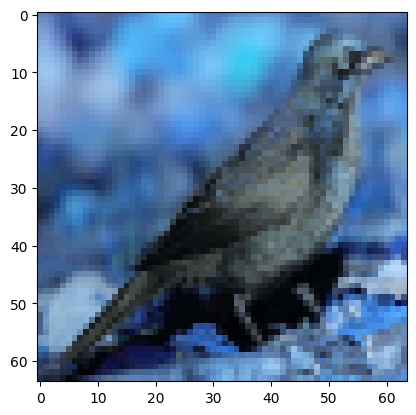

In [ ]:
plt.imshow(X_train[12,:,:])
plt.show()

Size=128X128

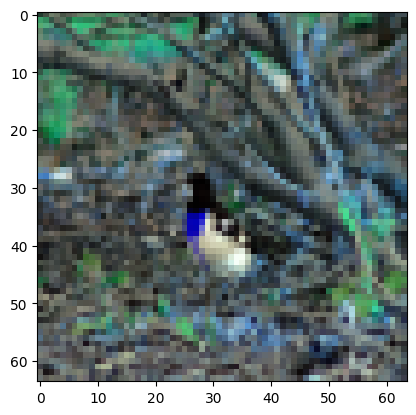

In [ ]:
plt.imshow(X_train[2101,:,:])
plt.show()

###CNN Architecture Block

CUSTOM CNN:

This architecture performed consideraby better than other architectures I experimented.

In [ ]:
def create_model():
    model=Sequential()
    model.add(Conv2D(16, kernel_size = [3,3], padding = 'same', activation = 'relu', input_shape = (64,64,3)))
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))

    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))

    model.add(Conv2D(128, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(256, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))

    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(Dense(201, activation = 'softmax'))
    model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

    print('Model Created')
    model.summary()
    return model

def fit_model():
  model_hist=model.fit(X_train,y_train,batch_size=64,epochs=100,validation_split=0.125)
  return model_hist

You can see the last fully connected layer has 201 columns,this is because of the way we labelled the images , keras.to_categorical adds 1 to the number of classes,therefore  200+1= hence 201.

Taken from Keras documentation

Link: https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py

        num_classes = np.max(y) + 1
        n = y.shape[0]
        categorical = np.zeros((n, num_classes), dtype=dtype)
        categorical[np.arange(n), y] = 1



   


So in our y_train(one Hot Encoded) we will see that the first column has no values at all beacuse we didnt start labelling with 0 we did it with 1.
As you can see there are no labels in the 1st column.Maximum value in this column is 0 which means no label is being stored.
Hope this ambuigity is clear.

You can also change the way you label but the results will remain identical.

In [ ]:
z=y_train[:,0];np.max(z)

0.0

In [ ]:
z=y_train[:,200];np.max(z)

1.0

 Key Takeaways:

 1.You can see 201 is out of bounds, which means labels starts from 0 and ends at 200

 2.In our case Label 0 has no image of its kind becuse there are no images of its kind this is the way we constructed our label_dict dictionary.

In [ ]:
z=y_train[:,201];np.max(z)

IndexError: ignored

###Training Block

In [ ]:
model=create_model()
curr_model_hist=fit_model()

Model Created
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 21, 21, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
evaluate_metrics=model.evaluate(X_test,y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluatation Loss = ","{:.6f}%".format(evaluate_metrics[0]))

148/148 [==============================] - 24s 159ms/step - loss: 3.4870 - accuracy: 0.4724

Evaluation Accuracy =  47.24% 
Evaluatation Loss =  3.487035%
